In [500]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils 

plt.style.use('ggplot')
%matplotlib inline

,id,height,weight
249,250,167.484933,38.264930
727,728,160.338770,37.686814
2651,2652,153.956131,39.937170
3515,3516,162.482149,38.493382
5366,5367,169.273652,39.454339
5705,5706,159.708393,39.312365
6347,6348,163.860099,39.235368
8317,8318,165.123393,38.221000
10240,10241,157.306061,38.687043
12446,12447,164.439778,39.634461


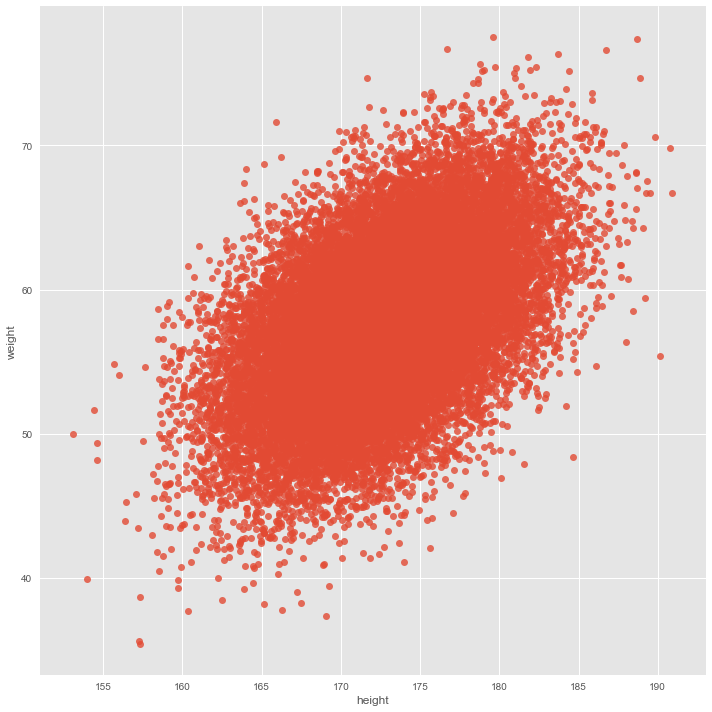

In [506]:
data = pd.read_csv('height.txt', sep=';')
data['weight']*=0.453592
data['height']*=2.54
sns.lmplot(x='height', y='weight', data=data.loc[:], fit_reg=False, size=10)
data.loc[data['weight']<40]

In [542]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')
test['cardio']=-5
data = pd.concat((train,test), axis=0)

In [545]:
data.loc[data["ap_hi"] < 0]

data.loc[data["ap_lo"] < 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,22571,1,167,74.0,15,-70,1,1,0.0,0.0,1.0,1
24125,80604,19600,2,170,92.0,140,-90,1,1,1.0,1.0,1.0,-5


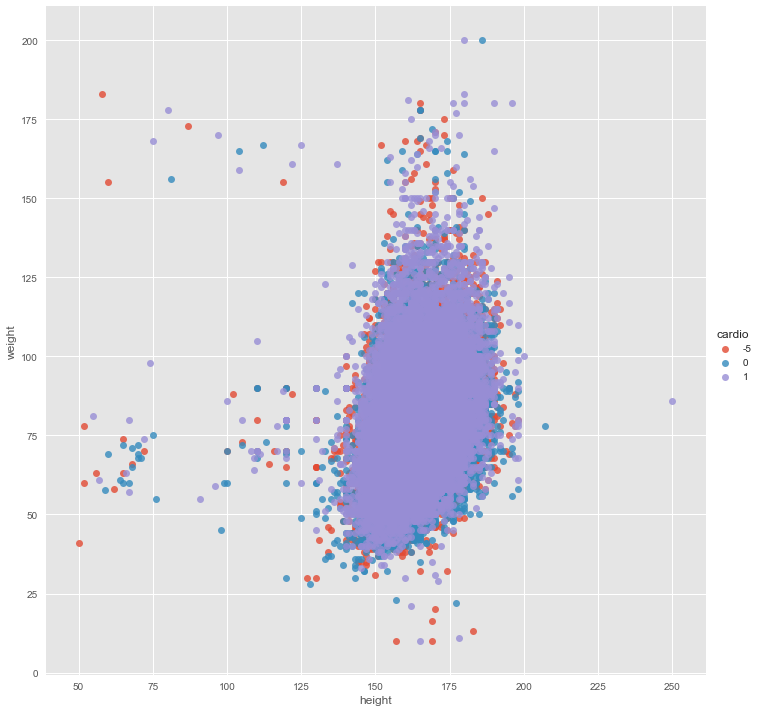

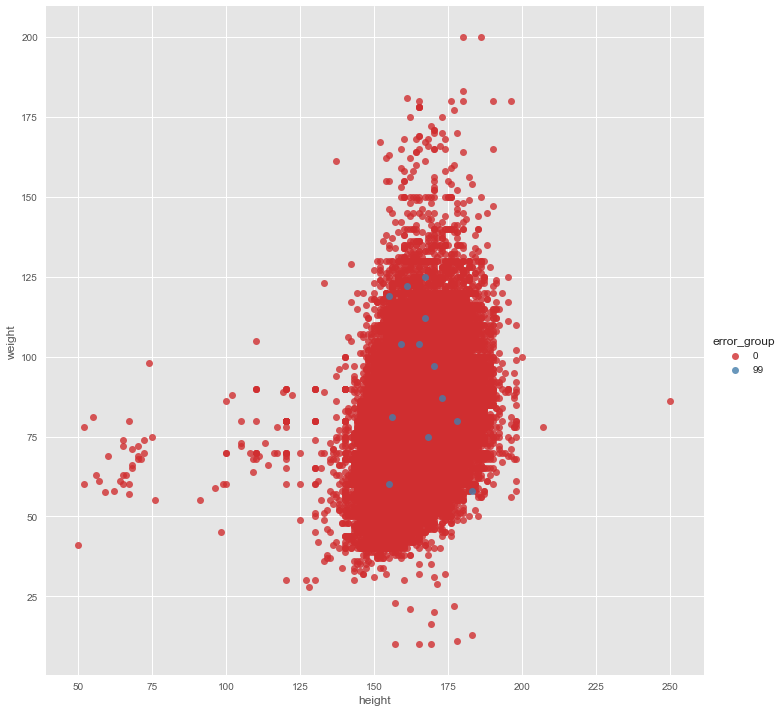

In [632]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')
test['cardio']=-5
data = pd.concat((train,test), axis=0)

sns.lmplot(x='height', y='weight', data=data.loc[:], hue='cardio', fit_reg=False, size=10)
data['error_group'] = 0


# weight/height correction
idx = (data['height']<130) & (data['weight']>150)
data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
data.loc[idx, 'error_group'] = 100-1

# idx=(data['height']<100)
# data.loc[idx, 'error_group'] = 100-2
# data.loc[(data['height']<100), 'height'] += 100

# data.loc[(data['weight']<20)&(data['weight']%1!=0), 'weight'] *= 10

# idx = (data['weight']<35)&((data['height']<138))&(data['weight']//10 == 3)
# data.loc[idx, 'weight'] = 80 + data.loc[idx, 'weight']%10
# # data.loc[idx, 'error_group'] = 100-4

# idx = (data['weight']<35)&((data['height']<138)|(data['height']>155))
# data.loc[idx, 'weight'] += 100
# data.loc[idx, 'error_group'] = 100-3


# preasure correction

data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1


# data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
# data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
# data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
# data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
# data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
# data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4


# data.loc[data["ap_hi"] == -12, "ap_hi"] = 120


data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

idx = data['ap_hi'] > 10000
data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100

data.loc[data['ap_lo'].isin([1000,1200]), 'ap_lo'] /= 10





manual_update = [
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
    ]
for idx, cols, update in manual_update:
    data.loc[data['id']==idx, cols] = update

# data.loc[(data['ap_lo']>200), 'cardio']=10
# data.loc[(data['weight']<35)&(data['height']>155), 'cardio']=10
sns.lmplot(x='height', y='weight', data=data.loc[:], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.8))
# sns.lmplot(x='ap_lo', y='ap_hi', data=data.loc[:], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

In [622]:
U = data.loc[data['cardio']>=0]
U.groupby('error_group')['cardio'].mean()

error_group
0     0.494946
1     0.851453
2     0.541667
3     0.580645
4     0.777778
5     0.370370
6     0.497297
96    0.000000
98    0.363636
99    0.666667
Name: cardio, dtype: float64

In [623]:
K = U.groupby('error_group').size()
mean_loc = U.groupby('error_group')["cardio"].mean()
glob_mean = U['cardio'].mean()
alpha=10
values = (mean_loc * K + glob_mean * alpha) / (K + alpha)
values

error_group
0     0.494947
1     0.847707
2     0.529324
3     0.560902
4     0.631421
5     0.405324
6     0.497421
96    0.454273
98    0.406156
99    0.578789
dtype: float64

In [624]:
K

error_group
0     68763
1       929
2        24
3        31
4         9
5        27
6       185
96        1
98       22
99        9
dtype: int64

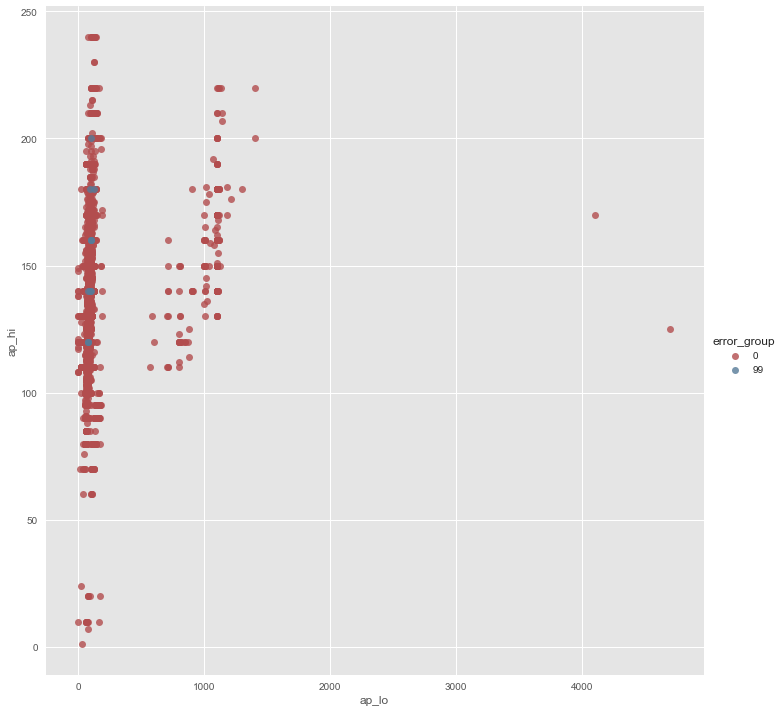

In [633]:
sns.lmplot(x='ap_lo', y='ap_hi', data=data.loc[(data['ap_hi']<250)&(data['ap_lo']<5000)], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

In [634]:
# sns.lmplot(x='weight', y='age', data=data.loc[(data['weight']<50)], hue='cardio', fit_reg=False, size=10)

In [635]:
# data.loc[(data['weight']<35)&((data['height']<140)|(data['height']>155))]
# data.loc[(data['weight']<20)&(data['weight']%1!=0)]

In [636]:
# data.loc[(data['weight']<35)&(data['height']>140)]

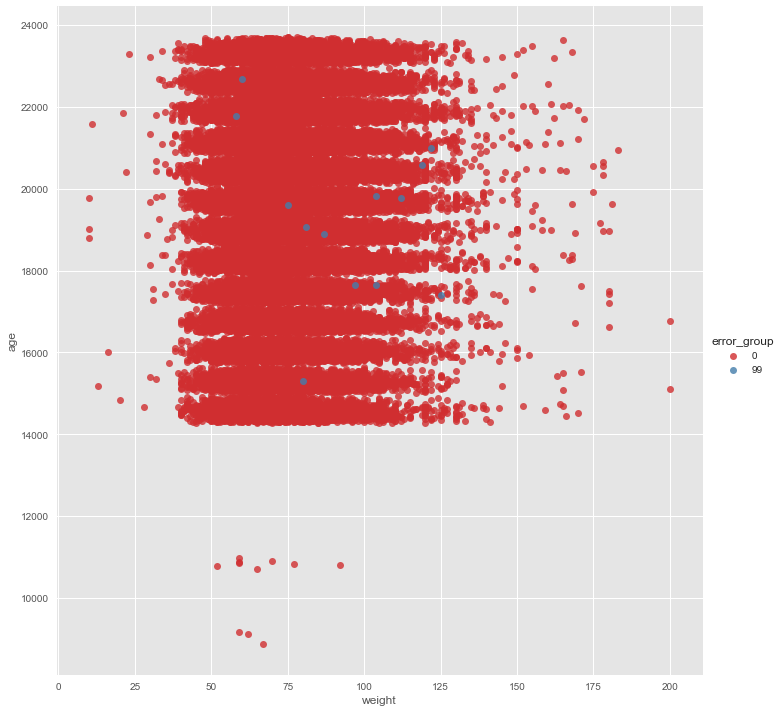

In [640]:
sns.lmplot(x='weight', y='age', data=data.loc[data['ap_hi']<250], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.8))

In [593]:
def clean_data(data):
    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
    data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10
    
    idx = (data['height']<130) & (data['weight']>150)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[data["height"] > 220, "height"] -= 100
#     data.loc[(data["ap_hi"] == 11500), "ap_hi"] = 115
#     data.loc[(data["ap_hi"] == 13010), "ap_hi"] = 110
    
    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100
    
    
#     data.loc[data['ap_hi']==906, ['ap_hi', 'ap_lo']] = [90, 60]
    
#     idx = (data['ap_hi']>250)&(data['ap_lo']==0)
#     data.loc[idx, 'ap_lo'] = (data.loc[idx, 'ap_hi'] % 10) * 10
    
    data.loc[data['ap_lo'].isin([1000,1200]), 'ap_lo'] /= 10
    
    data.loc[(data['height']<100)&(data['weight']>50), 'height'] += 100
    
    data.loc[(data['weight']<20)&(data['weight']%1!=0), 'weight'] *= 10
    idx = (data['weight']<35)&((data['height']<138))&(data['weight']//10 == 3)
    data.loc[idx, 'weight'] = 80 + data.loc[idx, 'weight']%10
#     idx = (data['weight']<35)&((data['height']<140)|(data['height']>155))&(data['weight']//10 == 1)
#     data.loc[idx, 'weight'] *=10
    idx = (data['weight']<35)&((data['height']<138)|(data['height']>155))
    data.loc[idx, 'weight'] += 100
#     data.loc[(data['weight']<35)&(data['height']>155), 'weight'] += 100
#     data.loc[(data['weight'] < 40), 'weight'] += 100
    
    
    
#     idx = (data['ap_lo']<250)&(data['ap_hi']<100)&(data['ap_hi']>50)&(data['ap_lo']>50)&(data['ap_hi']<data['ap_lo'])
#     data.loc[(data["ap_lo"] == 120) & (data["ap_hi"] == 80), ["ap_hi", "ap_lo"]] = [120, 80]

    
#     # one with 1/30 is updated manualy later
#     idx = data["ap_hi"] < 2
#     data.loc[idx, "ap_hi"] = 100 + data.loc[idx, "ap_lo"] // 100
#     data.loc[idx, "ap_lo"] = ((data.loc[idx, "ap_lo"] % 100) // 10) * 10
    
#     data.loc[(data['ap_lo'].isin([1000,1100,1200])), 'ap_lo'] //= 10
    
#     data.loc[(data["ap_hi"] == 20) & (data["ap_lo"] < 120), "ap_hi"] = 120
#     data.loc[(data["ap_hi"] == 20), "ap_hi"] = 200
    
#     data.loc[(data['ap_lo']>250)&(data['ap_lo']//1000==8), 'ap_lo']=80 #checked
# #     data.loc[(data["ap_lo"] == 30), "ap_lo"] = 60
    
# #     idx = (data['ap_lo']>150)&(data['ap_lo']<300)&(data['ap_lo']>data['ap_hi'])
# #     data.loc[idx, 'ap_lo'] = data.loc[idx, 'ap_lo'] % 100

   
#     data.loc[(data['ap_hi']%10!=0)&(data['ap_lo']>=250)&(data['ap_lo']<4000), 'ap_lo'] /= 10
    #--------------------------
    manual_update = [
        
# id	age	gender	height	weight	ap_hi	ap_lo	cholesterol	gluc	smoke	alco	active	cardio	BMI
# 12494	16905	2	163	63.0	1	2088	1	1	1.0	0.0	1.0	0	23.711845
# 42591	18191	2	162	63.0	140	1900	1	1	1.0	0.0	1.0	1	24.005487
# 78873	20323	1	168	68.0	130	1900	1	1	0.0	0.0	1.0	0	24.092971
# 51749	18419	1	169	62.0	1	2088	1	1	0.0	0.0	1.0	-5	21.707923
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        
# 57807	20496	1	164	62.0	70	1100	1	1	0.0	0.0	0.0	0	23.051755
# 60477	18716	1	171	80.0	1	1088	1	1	0.0	0.0	1.0	1	27.358845
# 91198	18182	2	186	95.0	100	901	2	2	0.0	0.0	1.0	0	27.459822
# 6580	19079	1	176	92.0	1	1099	1	1	0.0	NaN	1.0	-5	29.700413
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
        
# 44701	22801	1	163	115.0	20	170	1	1	0.0	0.0	1.0	1	43.283526
# 94673	22551	1	169	88.0	10	160	3	3	0.0	0.0	0.0	1	30.811246
        (44701, ['ap_hi', 'ap_lo'], [120, 70]),
        (94673,  ['ap_hi', 'ap_lo'], [110, 60]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
        

    return data

def new_features(data):
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = data["ap_lo"] + data["ap_dif"] / 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 10000, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = [25, 30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names)

    return data

In [594]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

# clear train
#train = train.loc[train["height"] < 249]
# train.reset_index(inplace=True, drop=True)

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)
#---------------------------------------
a = train['age_group']
# a.loc[a<3]=3
b = train['gender']
c = pd.qcut(train['height'] / train['weight'], 10, labels=False)
# d = pd.qcut(, 10, labels=False)
# d = pd.Series(y_train)
rew = a.apply(str) + b.apply(str) + c.apply(str) #+ d.apply(str)
rew.loc[rew.isin((rew).value_counts()[(rew).value_counts()<2].index)] = "hacky"
#----------------------------------------

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

columns_to_interact = ['age_group', 'gender', 'MAP']
temp = utils.generate_interactions(X_train, columns_to_interact, 2)
X_train = pd.concat((X_train, temp), axis=1)
X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
print(temp.columns)

X = pd.concat((X_train, X_test), axis=0)

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder_dict = defaultdict(LabelEncoder)
columns_to_encode = ['age_group'] + list(temp.columns)



X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

Index(['age_group_gender', 'age_group_MAP', 'gender_MAP'], dtype='object')


In [595]:
import utils
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model1",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )
# mean: 0.538599944338
# std: 0.00663422345597
# mean: 0.538529269411
# std: 0.0065680708081
# mean: 0.538654731161
# std: 0.00660647095064
# mean: 0.538556941713
# std: 0.00653815178635

# mean: 0.538431347552
# std: 0.00657830489213


10 folds logloss:
[0.53354721191466192, 0.54357221479207785, 0.54905059443232762, 0.53639169241628482, 0.53765276783032867, 0.52509813753859114, 0.54282120049743154, 0.5449532198227538, 0.53677685671996078, 0.53549654660831247]
mean: 0.538536044257
std: 0.0064702316745
15 Splits logloss:
[0.53905864880504928, 0.54249083824824418, 0.53912109897235638, 0.53327045984920618, 0.54337544377572289, 0.53299088270052486, 0.53811632023667233, 0.53383692911494962, 0.5383424345341552, 0.53869588164347049, 0.53630095746717243, 0.54284216472445268, 0.53726642686522519, 0.53990223976728802, 0.53512041375065933]
mean: 0.538048742697
std: 0.00322069311599
model1 results saved!


(0.53853604425727308, 0.53804874269700997)

In [447]:
# ids = X_train['id'].isin([12494,42591,78873,51749,57807,60477,91198,6580,])
# ids = X_train['id'].isin([2845,34120,60565,60948,92655,98095,24871,30877,88161,99929,])
ids = X_train['id'].isin([44701, 94673])

predict, _, _, _, = utils.load_model('model1')

from sklearn.metrics import log_loss
log_loss(y_train[ids], predict[ids])
# 0.92
# 0.69817735007823967

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [ ]:
10 folds logloss:
[0.53316211343285513, 0.5435962031879279, 0.54867728201528698, 0.53651873490238378, 0.53727909470172197, 0.52475207112291411, 0.54273463114564169, 0.54496225122940489, 0.53624431557193275, 0.53549874592974667]
mean: 0.538342544324
std: 0.00652689409999
15 Splits logloss:
[0.53888477666993306, 0.54218950152605772, 0.5392684533560792, 0.53284370407408765, 0.54322835531445401, 0.53276219115927792, 0.53799097376426674, 0.53380737949959212, 0.53834701399032414, 0.53868100204313374, 0.53622424516843592, 0.54254933874263722, 0.5373211861088083, 0.53968248019803311, 0.53515638711298441]
mean: 0.537929132582
std: 0.00321056488567


10 folds logloss:
[0.53340139800318942, 0.54402493769300042, 0.54889854919817616, 0.53657680791536166, 0.5376343916425822, 0.52487328929334087, 0.54225123099876382, 0.54505014110314798, 0.53629562514911466, 0.53622634612240239]
mean: 0.538523271712
std: 0.00649449868547
15 Splits logloss:
[0.53917368484789485, 0.54243159511267092, 0.53919880670322651, 0.53312569179410219, 0.54332352251426552, 0.53300622107990214, 0.53834041199188365, 0.53374835987972291, 0.53846484410674456, 0.53862878334299402, 0.53628739092451549, 0.54303022176322135, 0.53753077044533903, 0.53993105139769959, 0.5350797644216887]
mean: 0.538086741355
std: 0.00325468168847
model1 results saved!

In [245]:
pd.set_option('display.height', 1500)
pd.set_option('display.max_rows', 1500)

height has been deprecated.



In [293]:
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model2",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53309619741026915, 0.54426049582086922, 0.5488460179357062, 0.53640445089755162, 0.53768685199442678, 0.52572016629373697, 0.54272835154999355, 0.54497162565730295, 0.53610616940732658, 0.53524175466104007]
mean: 0.538506208163
std: 0.00643357027316
15 Splits logloss:
[0.53875560218652219, 0.54246766965352433, 0.53929984411642251, 0.53310826935333244, 0.54335626399859582, 0.53282380915734084, 0.53790313450247673, 0.53407827828408039, 0.53852253770629122, 0.53863050665254475, 0.53631115446890765, 0.54266201758247368, 0.53776244731639777, 0.54004525758979949, 0.5349251802834466]
mean: 0.538043464857
std: 0.0032243274211
model2 results saved!


(0.53850620816282224, 0.53804346485681043)

In [294]:
import lightgbm as lgb
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
#     'num_leaves': 2**3,
#     'min_child_weight': 1,
    'n_estimators': 50,
    'subsample': 0.8,
#     'reg_alpha': 1.2,
#     'reg_lambda': 0.0,
       
    'nthread': 1,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(lgb.LGBMClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model3",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53261609859371462, 0.54405774629520032, 0.5498107658696707, 0.53683321545776974, 0.53777399111967261, 0.52596781188028108, 0.54278366535671385, 0.54449829725613497, 0.53430483808968943, 0.53530618551718578]
mean: 0.538395261544
std: 0.00660168731988
15 Splits logloss:
[0.53801914652388727, 0.54231491104729879, 0.53969203127452336, 0.53312782193236852, 0.54365832355298982, 0.53307820378811865, 0.53749887098282434, 0.53401381577530305, 0.53855023153669923, 0.53876491349153344, 0.53634256462175578, 0.54237571624597192, 0.53756242950593225, 0.54003481112330542, 0.53493877772002951]
mean: 0.537998171275
std: 0.00320506057415
model3 results saved!


(0.5383952615436034, 0.53799817127483618)

In [ ]:
XP = X_train.copy()
XP['TARGET'] = y_train
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<300)&(XP['ap_lo']<4000)]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
# XP=XP.loc[(XP['TARGET']==0)]
# sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<=XP['ap_lo'])]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)